In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve


from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier



In [3]:
train=pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

## Checking for Missing Values

In [4]:
test.isna().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

## Checking Distribution of Target Variable 

In [5]:
train.shape

(2190, 13)

In [6]:
train['rainfall'].value_counts(normalize=True)

rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64

In [7]:
train.columns

Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall'],
      dtype='object')

In [8]:
train['day'].describe()

count    2190.000000
mean      179.948402
std       105.203592
min         1.000000
25%        89.000000
50%       178.500000
75%       270.000000
max       365.000000
Name: day, dtype: float64

In [9]:
train['year']=train['id']//365 + 1
train.groupby(train['year'])['day'].describe()

test['year']=test['id']//365 + 1
test.groupby(test['year'])['day'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
7,365.0,183.0,105.510663,1.0,92.0,183.0,274.0,365.0
8,365.0,183.0,105.510663,1.0,92.0,183.0,274.0,365.0


In [10]:
## Checking for missing values

missing_proportions = {}
for col in train.columns:
    missing_proportions[col] = train[col].isnull().sum()

print(missing_proportions)

{'id': 0, 'day': 0, 'pressure': 0, 'maxtemp': 0, 'temparature': 0, 'mintemp': 0, 'dewpoint': 0, 'humidity': 0, 'cloud': 0, 'sunshine': 0, 'winddirection': 0, 'windspeed': 0, 'rainfall': 0, 'year': 0}


## EDA And Visualization

### Boxplots of Explanatory variables segmented by Target classification

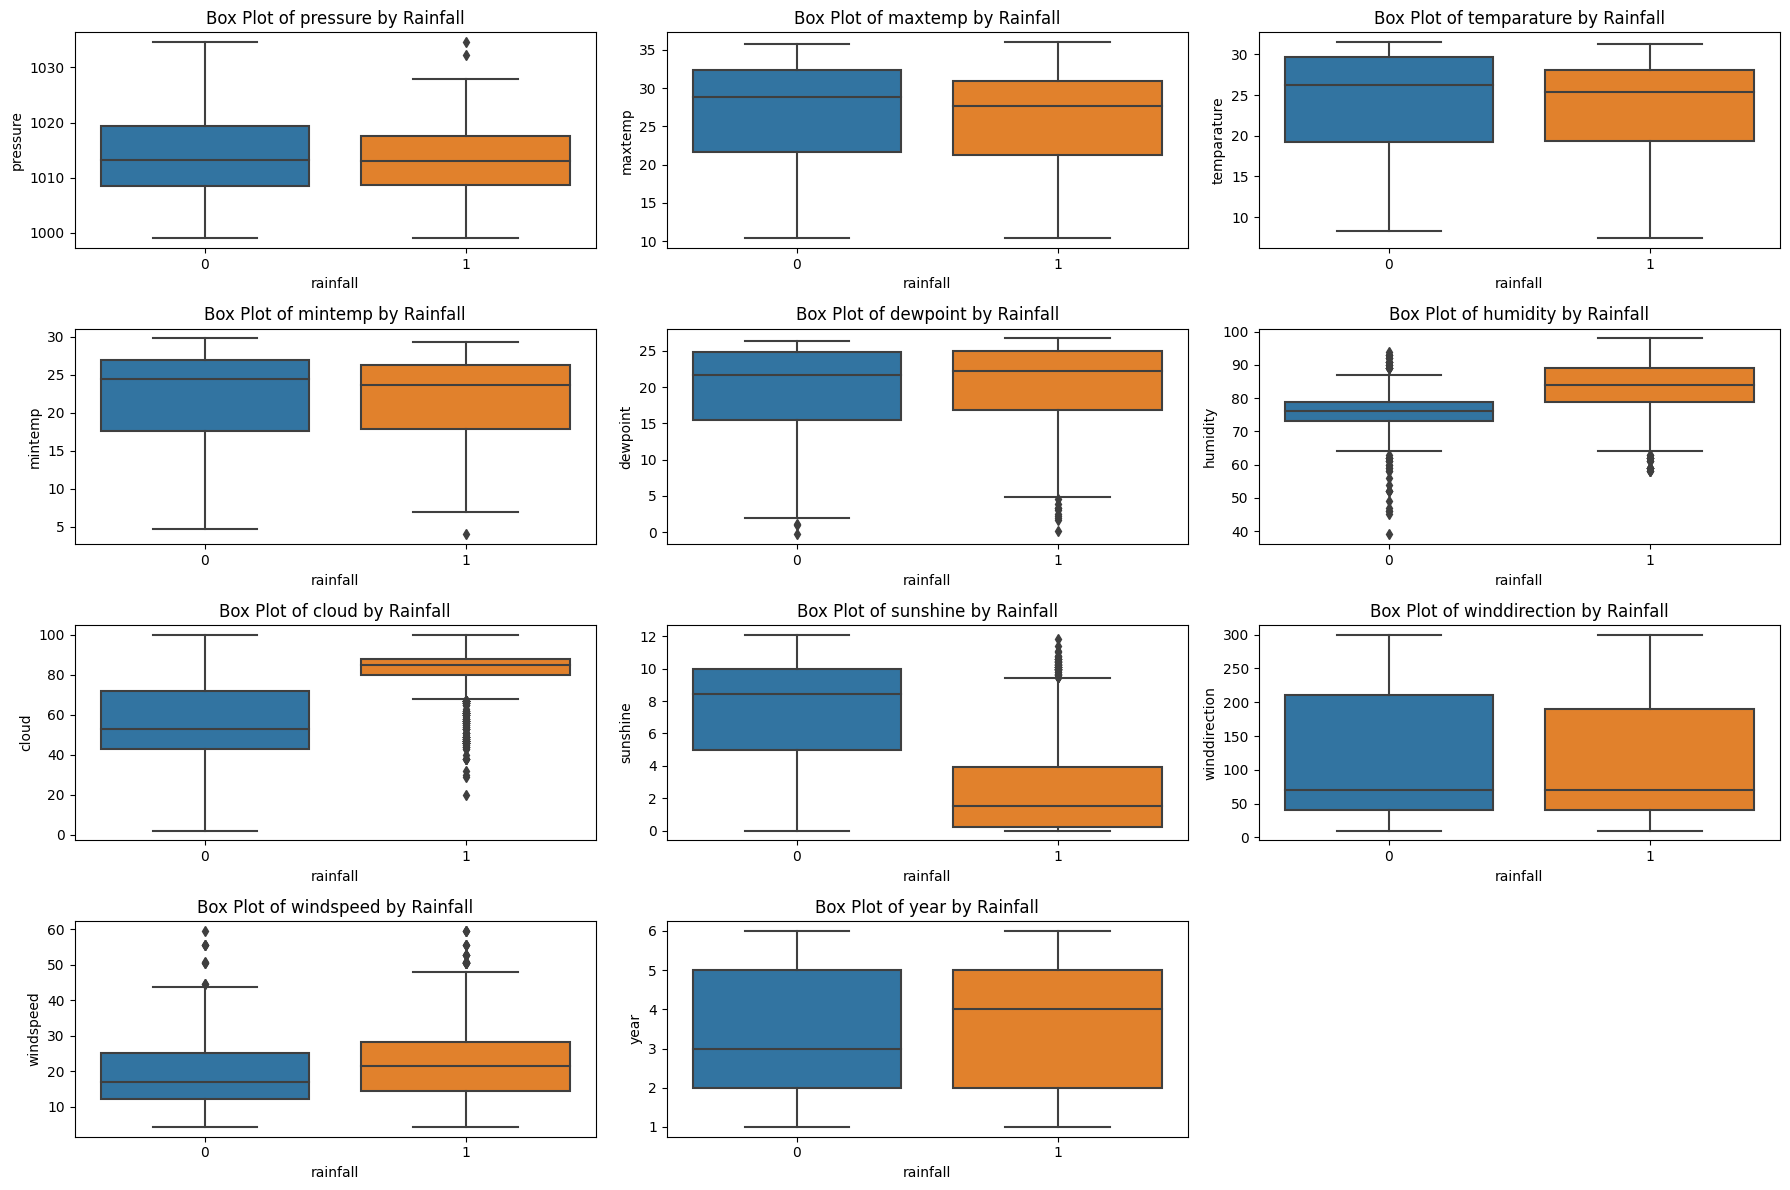

In [11]:
continuous_vars = list(train.drop(columns=['id','day','rainfall']).columns)

# Create subplots
num_cols = 3
num_rows = -(-len(continuous_vars) // num_cols)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))  
axes = axes.flatten()

for i, var in enumerate(continuous_vars):
    sns.boxplot(x='rainfall', y=var, data=train, ax=axes[i])
    axes[i].set_title(f"Box Plot of {var} by Rainfall")



for j in range(len(continuous_vars), len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

In [12]:
# import matplotlib.pyplot as plt

# # Ensure 'year' column exists
# train['year'] = train['id'] // 365 + 1

# # Get unique years
# years = train['year'].unique()

# # Set up subplots
# fig, axes = plt.subplots(len(years), 1, figsize=(12, 4 * len(years)), sharex=True, sharey=True)

# # If only one year, convert axes to a list
# if len(years) == 1:
#     axes = [axes]

# # Plot each year separately
# for i, year in enumerate(years):
#     subset = train[train['year'] == year]
#     axes[i].plot(subset['day'], subset['rainfall'], linestyle='-', marker='o', markersize=2, color='blue', alpha=0.7)
#     axes[i].set_title(f'Binary Rainfall Time Series - Year {year}')
#     axes[i].set_ylabel('Rain (1=Yes, 0=No)')

# # Common X-label
# plt.xlabel('Day of Year')
# plt.tight_layout()
# plt.show()


## Feature Engineering


In [13]:
test['id'].describe()

count     730.000000
mean     2554.500000
std       210.877136
min      2190.000000
25%      2372.250000
50%      2554.500000
75%      2736.750000
max      2919.000000
Name: id, dtype: float64

### Creating variable transformations - squared, lag 1, and moving averages

In [14]:
def feature_engineering(df, dataset_type):
    df=df.sort_values(by=['id'])
    df['temp_diff'] = df['maxtemp'] - df['mintemp']
    df['avg_temp'] = (df['maxtemp'] + df['mintemp']) / 2

    for i in df.columns:
        df[f'{i}'] = df[i].fillna(method='ffill')

    if dataset_type == 'train':
        for i in df.drop(columns=['id', 'day', 'rainfall']).columns:
            df[f'{i}_m_avg']=df[i].rolling(window=5).mean().fillna(df[i].mean())
            df[f'{i}_sqr'] = df[i] ** 2
            df[f'{i}_lagged']=df[i].shift(1).fillna(df[i].mean())

    elif dataset_type == 'test':
        for i in df.drop(columns=['id', 'day']).columns:
            df[f'{i}_m_avg']=df[i].rolling(window=5).mean().fillna(df[i].mean())
            df[f'{i}_sqr'] = df[i] ** 2
            df[f'{i}_lagged']=df[i].shift(1).fillna(df[i].mean())


    return df

In [15]:
train_final=feature_engineering(train,'train')


<ipython-input-14-a98eba8bf782>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f'{i}'] = df[i].fillna(method='ffill')


In [16]:
train_final.isna().mean()

id                      0.0
day                     0.0
pressure                0.0
maxtemp                 0.0
temparature             0.0
mintemp                 0.0
dewpoint                0.0
humidity                0.0
cloud                   0.0
sunshine                0.0
winddirection           0.0
windspeed               0.0
rainfall                0.0
year                    0.0
temp_diff               0.0
avg_temp                0.0
pressure_m_avg          0.0
pressure_sqr            0.0
pressure_lagged         0.0
maxtemp_m_avg           0.0
maxtemp_sqr             0.0
maxtemp_lagged          0.0
temparature_m_avg       0.0
temparature_sqr         0.0
temparature_lagged      0.0
mintemp_m_avg           0.0
mintemp_sqr             0.0
mintemp_lagged          0.0
dewpoint_m_avg          0.0
dewpoint_sqr            0.0
dewpoint_lagged         0.0
humidity_m_avg          0.0
humidity_sqr            0.0
humidity_lagged         0.0
cloud_m_avg             0.0
cloud_sqr           

In [17]:
test_final=feature_engineering(test,'test')

<ipython-input-14-a98eba8bf782>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f'{i}'] = df[i].fillna(method='ffill')


In [18]:
test_final.isna().mean()

id                      0.0
day                     0.0
pressure                0.0
maxtemp                 0.0
temparature             0.0
mintemp                 0.0
dewpoint                0.0
humidity                0.0
cloud                   0.0
sunshine                0.0
winddirection           0.0
windspeed               0.0
year                    0.0
temp_diff               0.0
avg_temp                0.0
pressure_m_avg          0.0
pressure_sqr            0.0
pressure_lagged         0.0
maxtemp_m_avg           0.0
maxtemp_sqr             0.0
maxtemp_lagged          0.0
temparature_m_avg       0.0
temparature_sqr         0.0
temparature_lagged      0.0
mintemp_m_avg           0.0
mintemp_sqr             0.0
mintemp_lagged          0.0
dewpoint_m_avg          0.0
dewpoint_sqr            0.0
dewpoint_lagged         0.0
humidity_m_avg          0.0
humidity_sqr            0.0
humidity_lagged         0.0
cloud_m_avg             0.0
cloud_sqr               0.0
cloud_lagged        

## Performing PCA

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = train_final.drop('rainfall', axis=1)
y = train_final['rainfall']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

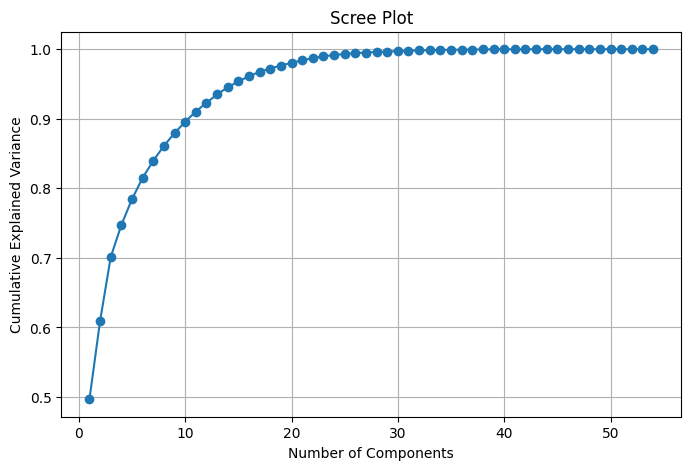

In [20]:
pca = PCA()
pca.fit(X_scaled)

# Plot Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid()
plt.show()

In [21]:
ideal_comp=15
pca = PCA(n_components=ideal_comp)  
principal_components = pca.fit_transform(X_scaled)

# Convert to DataFrame
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC_{i}' for i in range(1,ideal_comp+1)])

# Explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Visualize the results
# plt.figure(figsize=(8, 6))
# plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('PCA Visualization')
# plt.grid()
# plt.show()

Explained Variance Ratio: [0.4968309  0.11266059 0.09167082 0.04623744 0.03705905 0.03068165
 0.02452194 0.02138985 0.01829321 0.01635237 0.01473876 0.01246559
 0.01216189 0.01004486 0.00857872]


In [22]:
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(ideal_comp)])
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,2.034302,-1.361270,-2.018965,0.800991,-1.042721,-1.291220,-1.287694,-0.229448,-0.156009,1.733250,-0.375334,-0.962140,-0.051466,-0.455705,-1.085729
1,4.694651,-2.327784,-2.730824,0.441403,-0.861431,-1.448309,-1.566087,-0.825576,-0.042181,0.227844,-0.242562,-2.577929,0.197718,-0.393951,-1.431082
2,4.876427,2.975361,-2.667362,-3.776831,0.167462,0.187648,-1.267691,-0.828624,-0.116879,-0.564495,-0.714877,-1.606004,-0.371436,-0.912265,-1.127384
3,4.630770,-1.142578,-2.665055,4.196449,-0.474264,-0.606713,-2.032426,-1.542051,-0.342930,0.105383,-0.273866,-0.194129,0.386476,0.547310,0.167821
4,5.911441,4.125456,-3.170347,-4.329447,1.605152,1.345433,-0.202735,1.167454,-0.443609,0.978190,-2.698628,-0.976107,-0.017243,-1.355782,0.169500


## Fitting Decision Tree - Basic model to understand variable importance and setting baseline metrics


In [23]:

X=pca_df
y=train_final['rainfall']

In [24]:


X_train,X_test,y_train,y_test = train_test_split(X,y, stratify=y,test_size=0.2, random_state=42)
# X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)


In [25]:
y_train.shape

(1752,)

In [26]:
# smote = SMOTE(sampling_strategy='auto', random_state=42,k_neighbors=5)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [27]:
y_train.value_counts()
# y_train_resampled.value_counts()

rainfall
1    1320
0     432
Name: count, dtype: int64

In [28]:
clf = DecisionTreeClassifier(max_depth=5,random_state=42,min_samples_leaf=round(len(X_train)/100))
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=18, random_state=42)

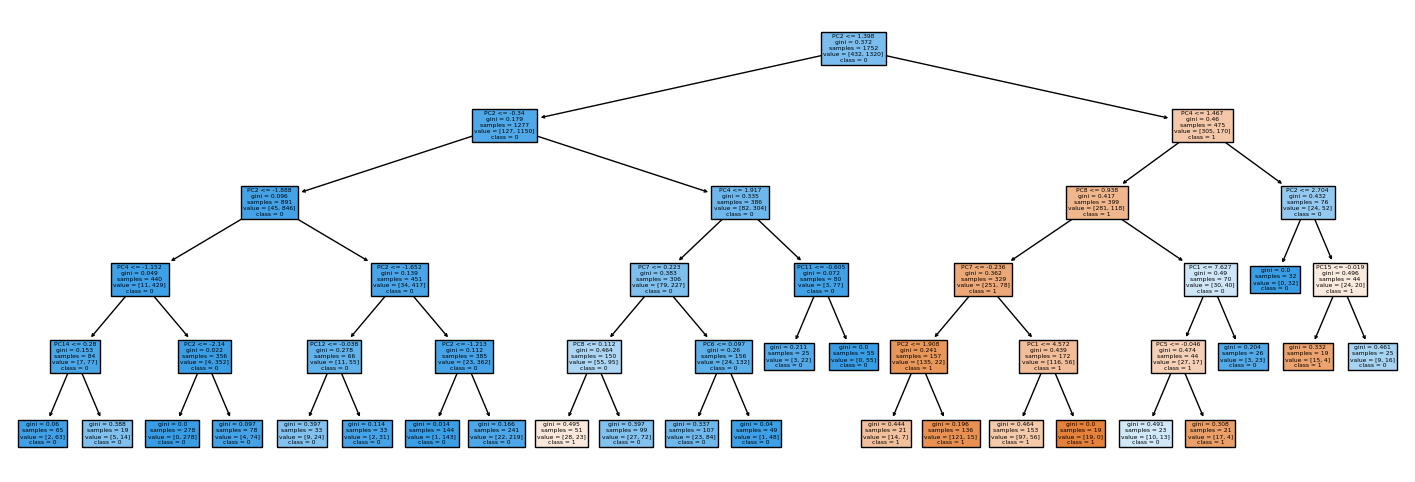

In [29]:
plt.figure(figsize=(18, 6))
class_names = [str(cls) for cls in y_train.unique()] 
plot_tree(clf, feature_names=X_train.columns, class_names=class_names, filled=True)

plt.savefig("decision_tree_rainfall_pca.png", dpi=500, bbox_inches='tight')
plt.show()


In [30]:
y_pred = clf.predict(X_test)


In [31]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8265
Precision: 0.8780
Recall: 0.8939
F1-score: 0.8859

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.62      0.64       108
           1       0.88      0.89      0.89       330

    accuracy                           0.83       438
   macro avg       0.77      0.76      0.76       438
weighted avg       0.82      0.83      0.82       438



> *The recall for the minority class is low as expected. We will be using undersampling and oversampling methods to improve this metric*

In [32]:

y_probs = clf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Select threshold where precision and recall are balanced
optimal_idx = (precision + recall).argmax()
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)
# Make new predictions
y_pred_new = (y_probs > optimal_threshold).astype(int)

0.45098039215686275


## Logistic Regression


In [33]:
y_train.value_counts()

rainfall
1    1320
0     432
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


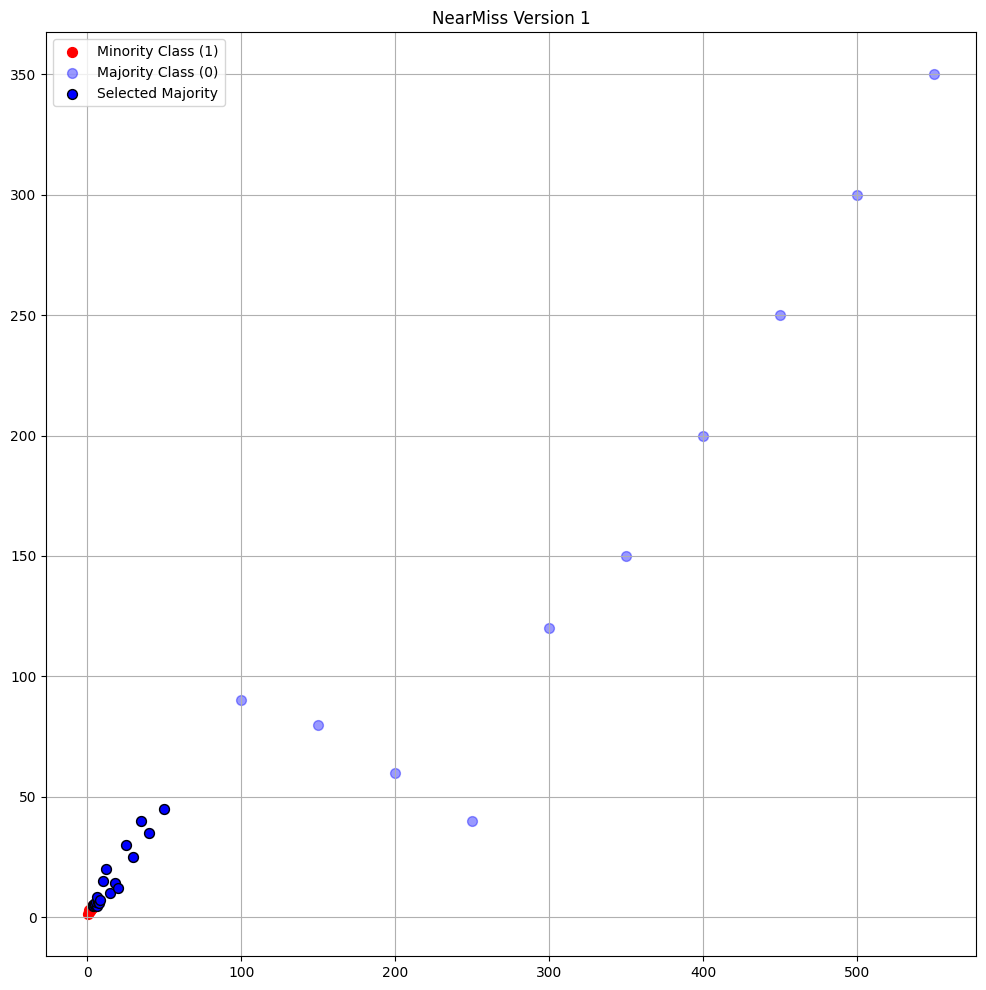

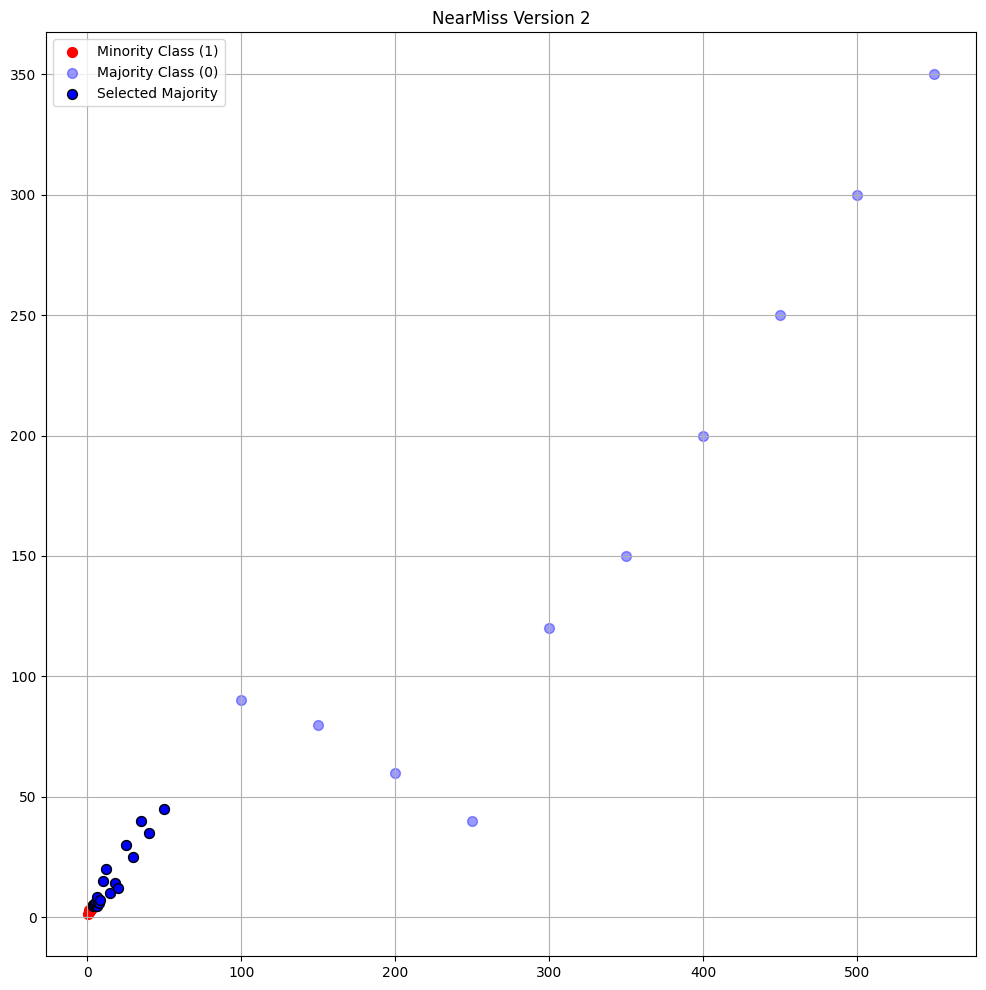

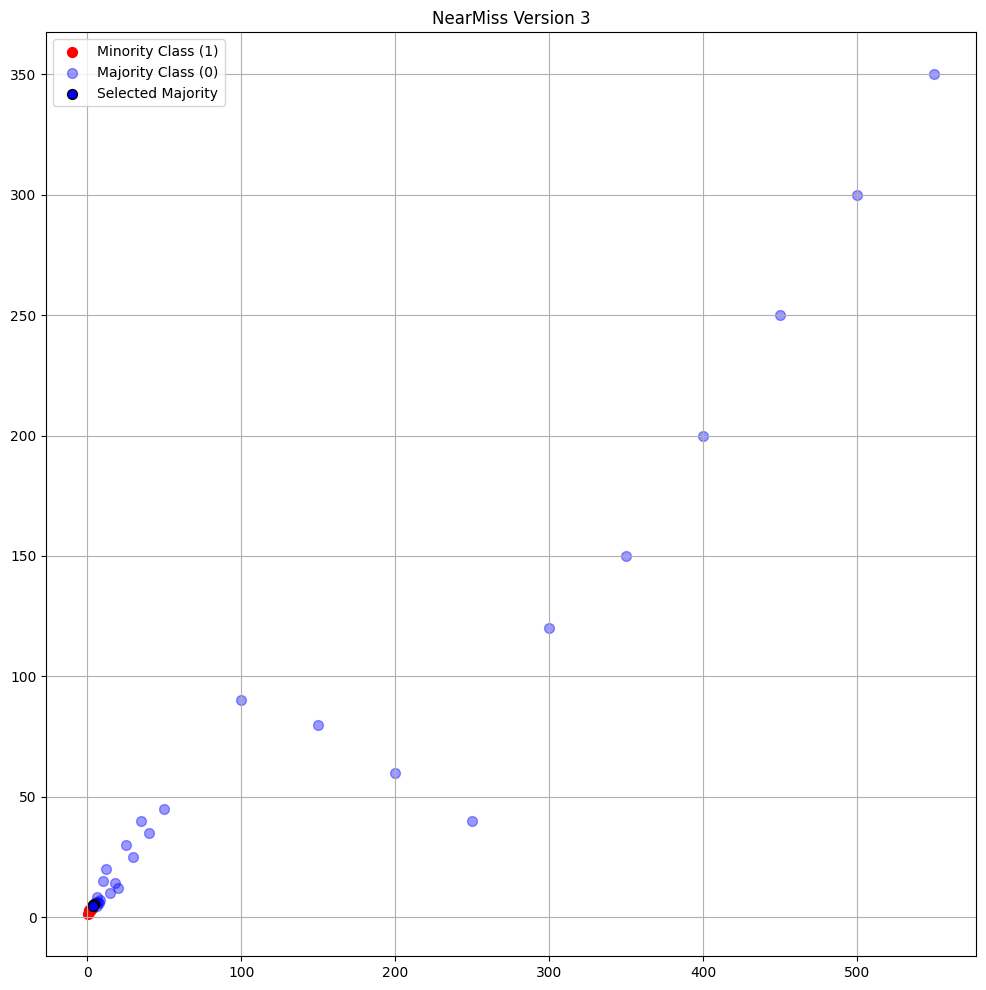

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import NearMiss

# Specify the fraction of data you want to sample (e.g., 30%)
minority_class = np.array([
    [1, 2], [2, 3], [3, 4], [1.5, 2.5], [2.8, 3.8],
    [0.7, 1.2], [3.3, 4.5], [1.1, 2.8], [2.2, 3.3], [3.1, 3.9]
])

# Diverse majority class
majority_class = np.array([
    # Close to minority class but not overlapping
    [4, 5], [3.5, 4.7], [5.5, 6.1], [4.2, 5.3], [6, 4.8], 
    [5.1, 5.5], [7.2, 6.5], [8, 7], [6.5, 8.3], [7.8, 5.9],
    
    # Further majority class points
    [15, 10], [10, 15], [20, 12], [18, 14], [12, 20],
    [30, 25], [25, 30], [40, 35], [35, 40], [50, 45],
    
    # Distant outliers
    [100, 90], [150, 80], [200, 60], [250, 40], [300, 120],
    [350, 150], [400, 200], [450, 250], [500, 300], [550, 350]
])
# Combining data and labels
X_sample = np.vstack((minority_class, majority_class))
y_sample = np.array([1]*len(minority_class) + [0]*len(majority_class))
# Perform NearMiss for each version
nearmiss_v1 = NearMiss(version=1, sampling_strategy=0.5)
nearmiss_v2 = NearMiss(version=2, sampling_strategy=0.5)
nearmiss_v3 = NearMiss(version=3, sampling_strategy=0.5)

X_v1, y_v1 = nearmiss_v1.fit_resample(X_sample, y_sample)
X_v2, y_v2 = nearmiss_v2.fit_resample(X_sample, y_sample)
X_v3, y_v3 = nearmiss_v3.fit_resample(X_sample, y_sample)

# Plotting function
def plot_nearmiss(title, X_resampled, y_resampled):
    plt.figure(figsize=(12,12))
    plt.scatter(X_sample[y_sample == 1][:, 0], X_sample[y_sample == 1][:, 1], color='red', label='Minority Class (1)', s=50)
    plt.scatter(X_sample[y_sample == 0][:, 0], X_sample[y_sample == 0][:, 1], color='blue', label='Majority Class (0)', s=50, alpha=0.4)
    plt.scatter(X_resampled[y_resampled == 0][:, 0], X_resampled[y_resampled == 0][:, 1], 
                color='blue', edgecolor='black', s=50, marker='o', label='Selected Majority')
    plt.title(title)
    plt.legend()
    plt.grid(True)

# Plot results for each NearMiss version
plot_nearmiss('NearMiss Version 1', X_v1, y_v1)
plot_nearmiss('NearMiss Version 2', X_v2, y_v2)
plot_nearmiss('NearMiss Version 3', X_v3, y_v3)

plt.show()


/usr/local/lib/python3.10/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


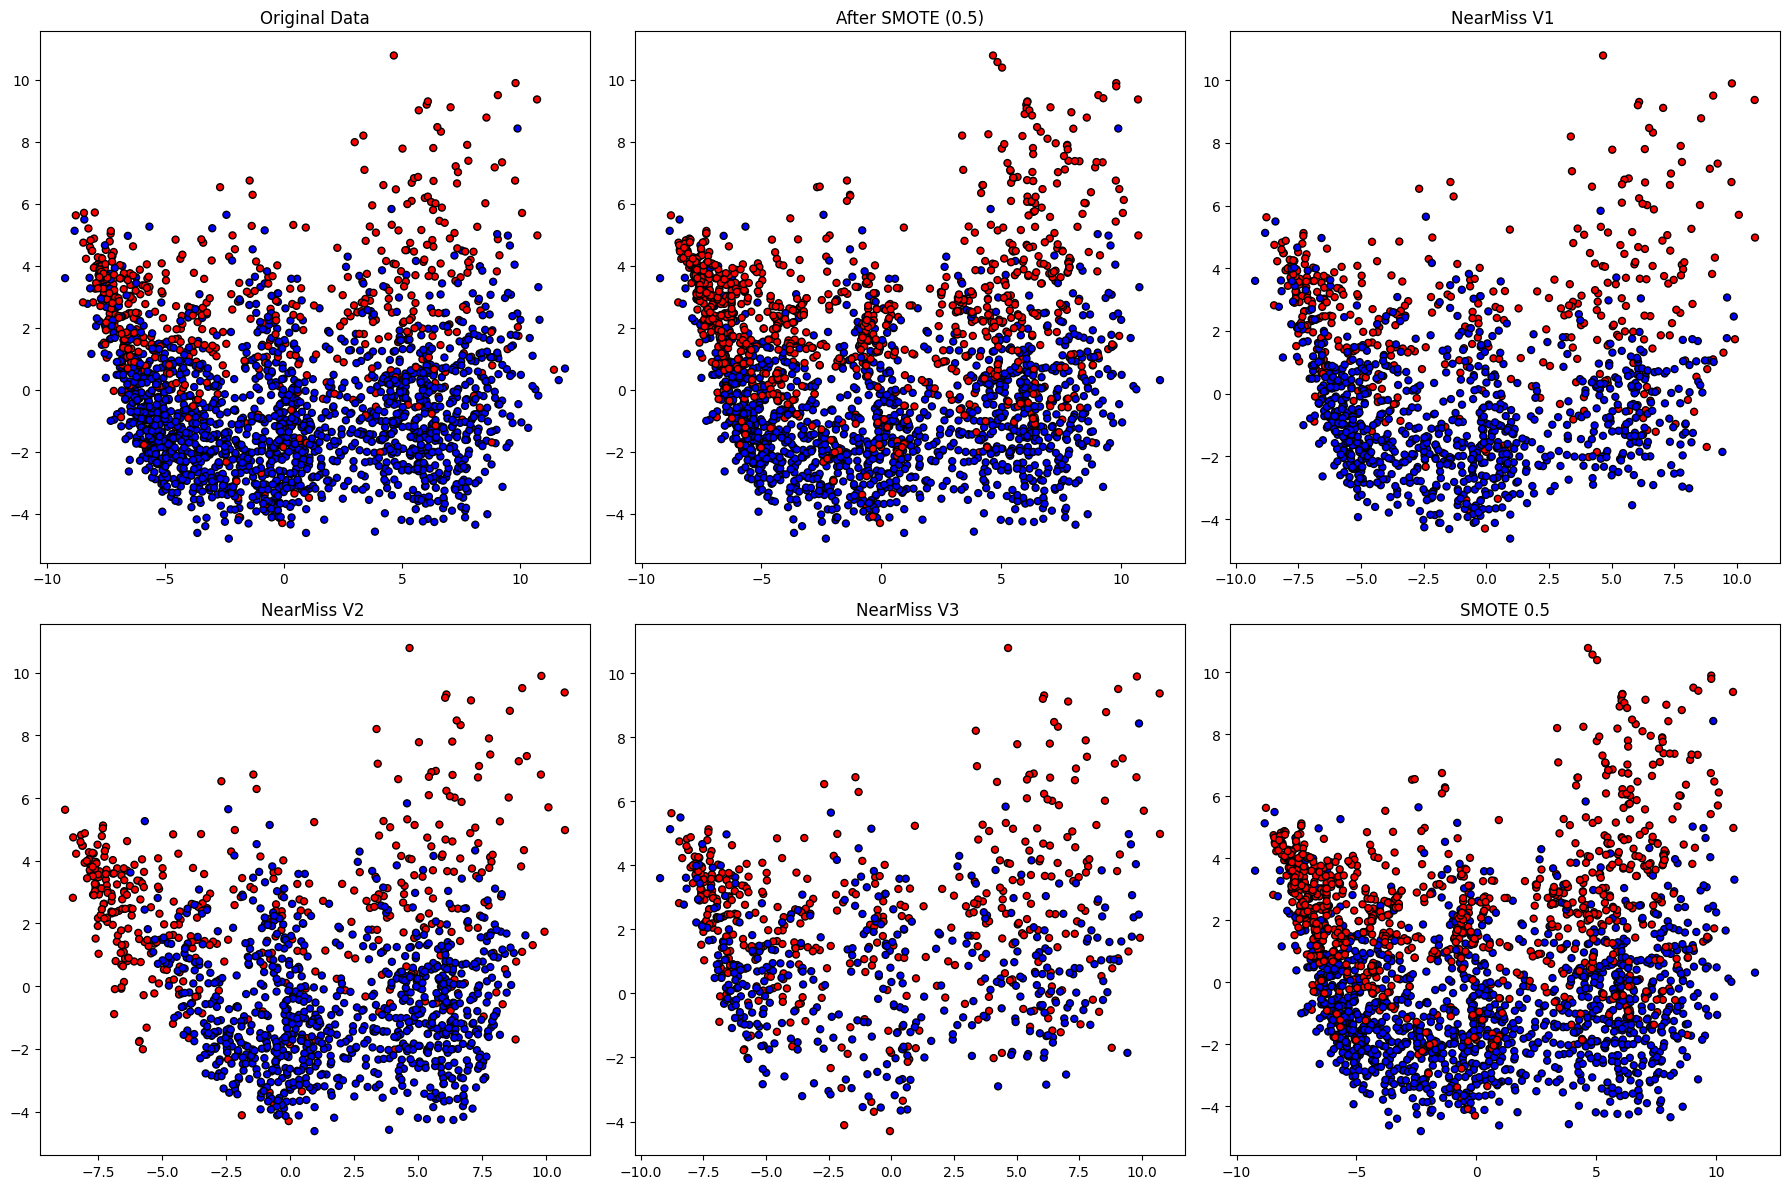

In [35]:
# smote = SMOTE(sampling_strategy=0.5, random_state=42,k_neighbors=2)
# X_smote, y_smote = smote.fit_resample(X_train, y_train)

# X_smote, y_smote=X_train,y_train
# Initialize NearMiss for all versions

smote = SMOTE(sampling_strategy=0.75, random_state=42,k_neighbors=2)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
nearmiss_v1 = NearMiss(version=1,sampling_strategy=0.5,n_neighbors_ver3=2)
nearmiss_v2 = NearMiss(version=2,sampling_strategy=0.5,n_neighbors_ver3=2)
nearmiss_v3 = NearMiss(version=3,sampling_strategy=0.5,n_neighbors_ver3=2)

# Apply NearMiss after SMOTE
X_nm1, y_nm1 = nearmiss_v1.fit_resample(X_train, y_train)
X_nm2, y_nm2 = nearmiss_v2.fit_resample(X_train, y_train)
X_nm3, y_nm3 = nearmiss_v3.fit_resample(X_train, y_train)

# Plotting function
def plot_data(X, y, title, ax):
    colors = ['blue' if label == 1 else 'red' for label in y]
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=colors, edgecolor='k', s=25)
    ax.set_title(title)

# Create the plot
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Original data
plot_data(X, y, 'Original Data', axs[0, 0])

# After SMOTE
plot_data(X_smote, y_smote, 'After SMOTE (0.5)', axs[0, 1])

# NearMiss Versions After SMOTE
plot_data(X_nm1, y_nm1, 'NearMiss V1 ', axs[0, 2])
plot_data(X_nm2, y_nm2, 'NearMiss V2 ', axs[1, 0])
plot_data(X_nm3, y_nm3, 'NearMiss V3 ', axs[1, 1])
plot_data(X_smote, y_smote,'SMOTE 0.5',axs[1,2])

# Hide empty subplot
# axs[1, 2].axis('off')

plt.tight_layout()
plt.savefig("Only_nearmiss_viz.png", dpi=500, bbox_inches='tight')
plt.show()


In [36]:
from sklearn.metrics import classification_report, make_scorer, recall_score


lr_pipeline = Pipeline([
    ('nearmiss', NearMiss(version=1,sampling_strategy=0.5)),
    ('logreg', LogisticRegression(solver='liblinear'))
])

# param_grid = {
#     'smote__sampling_strategy': [ 0.5, 0.7],
#     'smote__k_neighbors': [3, 5, 7],
#     'nearmiss__version': [1, 2, 3],
#     'nearmiss__n_neighbors': [3, 5, 7, 10],
#     'nearmiss__sampling_strategy': [0.3, 0.5, 0.7]
# }

# scorer = make_scorer(f1_score, average='binary')  

# grid_search = GridSearchCV(lr_pipeline, param_grid, scoring=scorer, cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)


# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)



In [37]:
# best_lr_model = grid_search.best_estimator_
lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)

Accuracy: 0.8584
Precision: 0.8988
Recall: 0.9152
F1-score: 0.9069

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.69      0.70       108
           1       0.90      0.92      0.91       330

    accuracy                           0.86       438
   macro avg       0.81      0.80      0.81       438
weighted avg       0.86      0.86      0.86       438



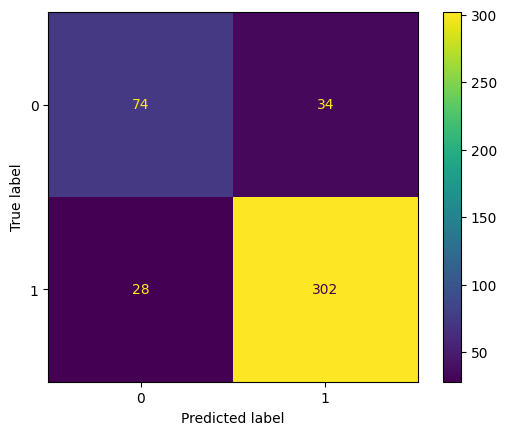

In [38]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred, labels=lr_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_pipeline.classes_)
disp.plot()

plt.show()

In [39]:
X_test_scaled = scaler.transform(test_final)
X_test_pca = pca.transform(X_test_scaled)
y_pred_submit = lr_pipeline.predict_proba(X_test_pca)[:, 1] 
submission = pd.DataFrame({
    "id": test["id"],  
    "rainfall": y_pred_submit  
})

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### SVM - presence of a clear boundary between two classes from visual inspection

Accuracy: 0.8744
Precision: 0.8963
Recall: 0.9424
F1-score: 0.9188

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.67      0.72       108
           1       0.90      0.94      0.92       330

    accuracy                           0.87       438
   macro avg       0.84      0.80      0.82       438
weighted avg       0.87      0.87      0.87       438



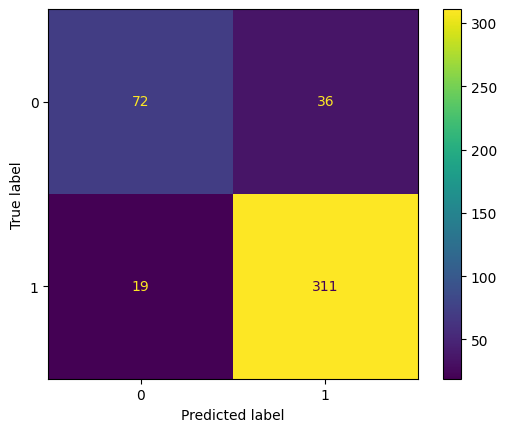

In [40]:
from sklearn.svm import SVC

svm_pipeline = SVC(kernel='linear', C=1.0, gamma='scale', probability=True)  


svm_pipeline.fit(X_train, y_train)

y_pred = svm_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred, labels=svm_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svm_pipeline.classes_)
disp.plot()

plt.show()

Accuracy: 0.8425
Precision: 0.9169
Recall: 0.8697
F1-score: 0.8927

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.76      0.70       108
           1       0.92      0.87      0.89       330

    accuracy                           0.84       438
   macro avg       0.79      0.81      0.80       438
weighted avg       0.85      0.84      0.85       438



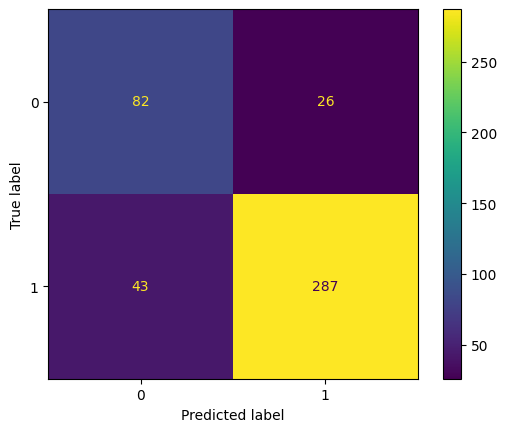

In [41]:
svc_nm_pipeline = Pipeline([
    ('nearmiss', NearMiss(version=1,sampling_strategy=0.8)),
    ('SVC', SVC(kernel='linear', C=1.0, gamma='scale', probability=True) )
])

 
svc_nm_pipeline.fit(X_train, y_train)

y_pred = svc_nm_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred, labels=svc_nm_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svc_nm_pipeline.classes_)
disp.plot()

plt.show()


In [42]:
X_test_scaled = scaler.transform(test_final)
X_test_pca = pca.transform(X_test_scaled)
y_pred_submit = svc_nm_pipeline.predict_proba(X_test_pca)[:, 1] 
submission = pd.DataFrame({
    "id": test["id"],  
    "rainfall": y_pred_submit  
})

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [43]:
submission

,id,rainfall
0,2190,0.828748
1,2191,0.826375
2,2192,0.717516
3,2193,0.047944
4,2194,0.010057
...,...,...
725,2915,0.896695
726,2916,0.766595
727,2917,0.872691
728,2918,0.908803


In [44]:
submission.to_csv('Ver7_SVC_Nearmiss_Corrected.csv',index=False)

### AdaBoost

In [45]:
adab_pipeline = Pipeline([
('nearmiss', NearMiss()),
('adaboost', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), random_state=42))
])

# Define hyperparameter grid including NearMiss sampling strategy
param_grid = {
    'nearmiss__sampling_strategy': [ 0.5, 0.7],
    'nearmiss__version': [1, 2, 3],
    'adaboost__n_estimators': [50, 100, 150, 200],
    'adaboost__learning_rate': [0.01, 0.03, 0.1, 1.0]
}

grid_search = GridSearchCV(adab_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [46]:
print(grid_search.best_params_)

{'adaboost__learning_rate': 0.01, 'adaboost__n_estimators': 150, 'nearmiss__sampling_strategy': 0.5, 'nearmiss__version': 1}


Accuracy: 0.8402
Precision: 0.8939
Recall: 0.8939
F1-score: 0.8939

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68       108
           1       0.89      0.89      0.89       330

    accuracy                           0.84       438
   macro avg       0.78      0.78      0.78       438
weighted avg       0.84      0.84      0.84       438



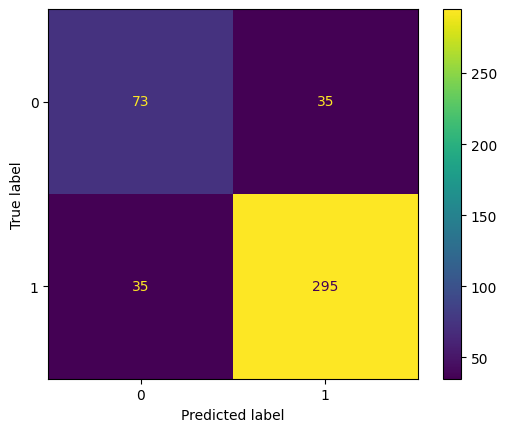

In [47]:
adab_pipeline=Pipeline([
    ('nearmiss', NearMiss(version=1,sampling_strategy=0.5)),
    ('model', AdaBoostClassifier(learning_rate=0.01,n_estimators=150,random_state=42))
])
adab_pipeline.fit(X_train, y_train)


y_pred = adab_pipeline.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred, labels=svc_nm_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svc_nm_pipeline.classes_)
disp.plot()

plt.show()

In [48]:
X_test_scaled = scaler.transform(test_final)
X_test_pca = pca.transform(X_test_scaled)
y_pred_submit = adab_pipeline.predict_proba(X_test_pca)[:, 1] 
submission = pd.DataFrame({
    "id": test["id"],  # Include ID column
    "rainfall": y_pred_submit  # Change to y_proba_kaggle if required
})

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


In [49]:
submission.to_csv('submission_ver9_adaboost_nearmiss.csv',index=False)

## Random Forest Classification

#### RandomizedSearch and BayesSearch CV with Pre-determined NearMiss strategy

In [50]:
rf_pipeline = Pipeline([
    ('nearmiss', NearMiss(version=1,sampling_strategy=0.5)),
    ('model', RandomForestClassifier(random_state=42))
])

param_distributions = {
    'model__n_estimators': [200, 400, 600, 800, 1000],
    'model__max_depth': [5, 10, 15, 20, 30, None],
    'model__min_samples_leaf': [1, 5, 10, 15, 30],
    'model__max_features': ['sqrt', 'log2', None],
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_samples': [0.5, 0.7, 0.9, None]
}



opt = RandomizedSearchCV(rf_pipeline, param_distributions, n_iter=30, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)
opt.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('nearmiss',
                                              NearMiss(sampling_strategy=0.5)),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'model__criterion': ['gini', 'entropy',
                                                             'log_loss'],
                                        'model__max_depth': [5, 10, 15, 20, 30,
                                                             None],
                                        'model__max_features': ['sqrt', 'log2',
                                                                None],
                                        'model__max_samples': [0.5, 0.7, 0.9,
                                                               None],
                                        'model__min_samples_leaf': [1, 5, 10,
                                                                    15, 30],
                                        'model__n_estimators': [200, 400, 600,
                                                                800, 1000]},
                   random_state=42, scoring='roc_auc')

In [51]:


rf_pipeline = Pipeline([
    ('nearmiss', NearMiss(version=1,sampling_strategy=0.5,n_neighbors=2)),
    ('model', RandomForestClassifier(random_state=42))
])

param_distributions = {
    'model__n_estimators': [200, 400, 600, 800, 1000],
    'model__max_depth': [5, 10, 15, 20, 30, None],
    'model__min_samples_leaf': [1, 5, 10, 15, 30],
    'model__max_features': ['sqrt', 'log2', None],
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_samples': [0.5, 0.7, 0.9, None]
}


# Perform Bayesian Optimization with Cross-Validation
opt_bayes = BayesSearchCV(rf_pipeline, param_distributions, n_iter=20, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)
opt_bayes.fit(X_train, y_train)





BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('nearmiss',
                                         NearMiss(n_neighbors=2,
                                                  sampling_strategy=0.5)),
                                        ('model',
                                         RandomForestClassifier(random_state=42))]),
              n_iter=20, n_jobs=-1, random_state=42, scoring='roc_auc',
              search_spaces={'model__criterion': ['gini', 'entropy',
                                                  'log_loss'],
                             'model__max_depth': [5, 10, 15, 20, 30, None],
                             'model__max_features': ['sqrt', 'log2', None],
                             'model__max_samples': [0.5, 0.7, 0.9, None],
                             'model__min_samples_leaf': [1, 5, 10, 15, 30],
                             'model__n_estimators': [200, 400, 600, 800, 1000]})

In [52]:
# Print best parameters -- RandomizedSearch
print("Best Parameters:", opt.best_params_)

# Print best parameters -- BayesSearch
print("Best Parameters:", opt_bayes.best_params_)

Best Parameters: {'model__n_estimators': 600, 'model__min_samples_leaf': 15, 'model__max_samples': 0.5, 'model__max_features': None, 'model__max_depth': 10, 'model__criterion': 'log_loss'}
Best Parameters: OrderedDict([('model__criterion', 'entropy'), ('model__max_depth', 5), ('model__max_features', None), ('model__max_samples', 0.7), ('model__min_samples_leaf', 15), ('model__n_estimators', 1000)])


In [53]:
best_params = opt_bayes.best_params_

# Extract only RandomForest parameters
rf_params = {k.replace('model__', ''): v for k, v in best_params.items() if k.startswith('model__')}

# Train RandomForest with the best parameters

rf_pipeline=Pipeline([
    ('nearmiss', NearMiss(version=1,sampling_strategy=0.5)),
    ('model', RandomForestClassifier(**rf_params,random_state=42))
])
# clf_rf = RandomForestClassifier(**rf_params, random_state=42)
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('nearmiss', NearMiss(sampling_strategy=0.5)),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        max_features=None, max_samples=0.7,
                                        min_samples_leaf=15, n_estimators=1000,
                                        random_state=42))])

In [54]:
y_pred = rf_pipeline.predict(X_test)

In [55]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8607
Precision: 0.9039
Recall: 0.9121
F1-score: 0.9080

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71       108
           1       0.90      0.91      0.91       330

    accuracy                           0.86       438
   macro avg       0.81      0.81      0.81       438
weighted avg       0.86      0.86      0.86       438



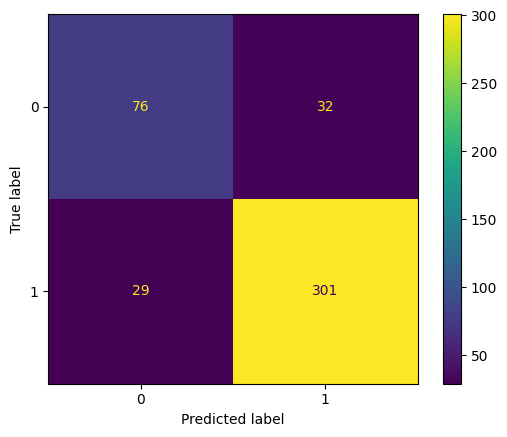

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=rf_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_pipeline.classes_)
disp.plot()

plt.show()

In [57]:
submission.to_csv('submission_ver10_rf_pca_nearmiss.csv',index=False)

### XGBoost

In [58]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=1000,  
    learning_rate=0.01,  
    max_depth=4,  
    subsample=0.8,  # Row sampling
    colsample_bytree=0.8,  # Feature sampling
    random_state=42)

# Fit the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [59]:
y_pred = xgb_model.predict(X_test)

In [60]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8607
Precision: 0.8832
Recall: 0.9394
F1-score: 0.9104

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.62      0.69       108
           1       0.88      0.94      0.91       330

    accuracy                           0.86       438
   macro avg       0.83      0.78      0.80       438
weighted avg       0.86      0.86      0.86       438



In [61]:

from skopt.space import Categorical, Integer, Real
# pipeline = Pipeline([
#     ('nearmiss',  NearMiss(version=1, sampling_strategy=0.5)),
#     ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric="auc", random_state=42))
# ])

pipeline = Pipeline([
    ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric="auc", random_state=42))
])

# Define the Bayesian search space
search_space = {
    # XGBoost Parameters
    'model__n_estimators': Integer(100, 500),
    'model__max_depth': Integer(3, 15),
    'model__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'model__reg_alpha': Real(0, 10),  # L1 regularization
    'model__max_delta_step': Integer(0, 10),  # Useful for highly imbalanced data
    'model__colsample_bylevel': Real(0.5, 1.0),  # Column sampling per tree level
    'model__colsample_bynode': Real(0.5, 1.0)  # Column sampling per node
}

# Bayesian optimization using BayesSearchCV
xgb_bayes_search = BayesSearchCV(
    pipeline,
    search_spaces=search_space,
    n_iter=50,  
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42
)

xgb_bayes_search.fit(X_train, y_train)

print("Best Parameters:", xgb_bayes_search.best_params_)


Best Parameters: OrderedDict([('model__colsample_bylevel', 1.0), ('model__colsample_bynode', 0.5), ('model__learning_rate', 0.03167336446428321), ('model__max_delta_step', 9), ('model__max_depth', 3), ('model__n_estimators', 181), ('model__reg_alpha', 0.0)])


In [62]:
best_xgb_bayes_params = xgb_bayes_search.best_params_
print("Best Parameters:", best_xgb_bayes_params)

xgb_params = {k.replace('model__', ''): v for k, v in best_xgb_bayes_params.items() if k.startswith('model__')}

# xgb_pipeline = Pipeline([
#     ('nearmiss', NearMiss(version=1,sampling_strategy=0.5)),
#     ('model', xgb.XGBClassifier(**xgb_params,random_state=42))
# ])

xgb_pipeline = Pipeline([
    ('model', xgb.XGBClassifier(**xgb_params,random_state=42))
])

xgb_pipeline.fit(X_train, y_train)




Best Parameters: OrderedDict([('model__colsample_bylevel', 1.0), ('model__colsample_bynode', 0.5), ('model__learning_rate', 0.03167336446428321), ('model__max_delta_step', 9), ('model__max_depth', 3), ('model__n_estimators', 181), ('model__reg_alpha', 0.0)])


Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=1.0, colsample_bynode=0.5,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.03167336446428321, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=9, max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=181, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [63]:
y_pred = xgb_pipeline.predict(X_test)

In [64]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8653
Precision: 0.8839
Recall: 0.9455
F1-score: 0.9136

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.62      0.69       108
           1       0.88      0.95      0.91       330

    accuracy                           0.87       438
   macro avg       0.84      0.78      0.80       438
weighted avg       0.86      0.87      0.86       438



In [65]:
test_final.shape

(730, 54)

In [66]:
X_test_scaled = scaler.transform(test_final)
X_test_pca = pca.transform(X_test_scaled)
y_pred_submit = xgb_pipeline.predict_proba(X_test_pca)[:, 1] 
submission = pd.DataFrame({
    "id": test["id"],  # Include ID column
    "rainfall": y_pred_submit  # Change to y_proba_kaggle if required
})

In [67]:
print("Predicted Probabilities:", y_pred_submit[:10])


Predicted Probabilities: [0.9562738  0.98472077 0.8980978  0.19615416 0.09406153 0.58249986
 0.86582357 0.9484036  0.8930195  0.77099603]


In [68]:
submission = pd.DataFrame({
    "id": test["id"],  # Include ID column
    "rainfall": y_pred_submit  # Change to y_proba_kaggle if required
})

In [69]:
submission.to_csv('submission_ver11_xgb_bayes.csv',index=False)